In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

import torch.nn.functional as F
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader

In [2]:
df=pd.read_csv('/kaggle/input/byjus-data-clean/Byjus.csv')

In [3]:
def convert_age(X):
    X = X.copy()
    X['age'] = pd.to_numeric(X['age'].astype(str).str.replace('+', '', regex=False), errors='coerce')
    X['age'] = pd.cut(X['age'], 
                      bins=[18, 22, 25, 28, 32, 35, float('inf')],
                      labels=['18-22', '23-25', '26-28', '29-32', '33-35', '35+'], 
                      right=True)
    return X

In [4]:
# Education mapping
education_mapping = {'engineering & technology': ['b.e / b-tech', 'bca/mca','m.e / m-tech', 'b.voc in networking and mobile applications', 
                                                  'b.arch', 'b.eng', 'b-tech', 'cse', 'bsc bedd - computer science', 'bachelors in engineering',
                                                  'food technology', 'biotechnology', 'masters in data science','mtech', 'btech', 'mca'],
                     
                     'bsc/msc': ['bsc', 'bsc or msc', 'bachelors in philosophy'],
                     'commerce & business': ['mba', 'b.com (bachelor of commerce)', 'b.com', 'b.comm', 'bba', 'bbm', 'bms', 'bachelor of business economics',
                                             'bcom computers','bms marketing', 'pgdm banking','bcom', 'bba or bbm', 'master in management'],
                     
                     'arts & humanities': ['ba', 'ba/ma', 'ma', 'bachelor mass communication', 'bachelors in design', 'bachelor of social work', 'bachelor in eco'],
                     'healthcare & medicine': ['b.pharma', 'med', 'bpharma', 'bds', 'b.physiotherapist', 'mbbs', 'pharma d', 'b -pharm', 'bachelor in medical lab', 'bachelor in dental'],
                     'social sciences': ['masters in social work', 'msw', 'masters in clinical psychology', 'masters in social science', 'masters in sociology'],
                     'diplomas & certifications': ['pgdm', 'pgdca', 'diploma', 'post graduation diploma', 'pgdf'],
                     'phd & doctorate': ['phd', 'doctorate',  'm.phil  2020'],
                     'vocational/technical': ['b.voc', 'vocational', 'bachelor of vocational','b voc - banking & finance'],
                     'hospitality & tourism': ['hotel management', 'masters in hospitality', 'tourism']}

def edu_function(degree):
    degree = str(degree).lower()
    for category, keywords in education_mapping.items():
        for keyword in keywords:
            if keyword.lower() in degree:
                return category
    return 'Other'

def categorize_degree(X):
    X = X.copy()
    X['Education'] = X['Education'].str.lower().fillna('Other')
    X['Education'] = X['Education'].apply(edu_function)
    return X

In [5]:
for col in df.columns:
    if df[col].nunique()>10:
        continue
    print(f"{col}----{df[col].nunique()}")

gender----2
marital_status----3
interview_mode----2
mother_tongue_influence_in_english----2
Anyone_spoken_before_applying----2
candidate_status----4
last_fixed_ctc_(lakhs)----8
currently_employed----2
experience_in_months----8
what_was_the_type_of_role?----3
how_many_slides_candidate_have_submitted_in_ppt?----8
role_acceptance----3
interview_verdict----5
candidate_is_willing_to_relocate----4
confidence_based_on_introduction_(english)----3
confidence_based_on_the_topic_given__----3
confidence_based_on_the_ppt_question----3
confidence_based_on_the_sales_scenario----3
structured_thinking_(in_regional_only)----3
structured_thinking_based_on_the_ppt_question----3
structured_thinking(_call_pitch)----3
regional_fluency_based_on_the_topic_given__----4
regional_fluency_based_on_the_ppt_question----4
regional_fluency_based_on_the__sales_scenario----4
confidence_score----9
structured_thinking_score----7
regional_fluency_score----10


In [6]:
def label_encoder(X):
    X = X.copy()
    label_encoders = {}
    categorical_cols = ['gender',
                        'marital_status',
                        'interview_mode', 
                        'mother_tongue_influence_in_english',
                        'Anyone_spoken_before_applying', 
                        'currently_employed',
                        'candidate_status']

    for col in categorical_cols:
        X[col] = X[col].fillna('Unknown')
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    return X

In [7]:
df['interview_verdict'] = df['interview_verdict'].replace({'Premium Select': 'Select', 'Borderline Select': 'Select', 'Borderline Reject': 'Reject'})

In [8]:
# Label encode the target
le_verdict = LabelEncoder()
df['interview_verdict'] = le_verdict.fit_transform(df['interview_verdict'])


In [9]:
numerical_cols = ['confidence_based_on_introduction_(english)',
                  'confidence_based_on_the_topic_given__',
                  'confidence_based_on_the_ppt_question',
                  'confidence_based_on_the_sales_scenario',
                  'structured_thinking_(in_regional_only)',
                  'structured_thinking_based_on_the_ppt_question',
                  'structured_thinking(_call_pitch)',
                  'regional_fluency_based_on_the_topic_given__',
                  'regional_fluency_based_on_the_ppt_question',
                  'regional_fluency_based_on_the__sales_scenario',
                  'confidence_score',
                  'structured_thinking_score',
                  'regional_fluency_score',
                  'total_score'
                 ]

categorical_cols = ['Education',
                    'gender',
                    'marital_status',
                    'interview_mode',
                    'mother_tongue_influence_in_english',
                    'Anyone_spoken_before_applying',
                    'currently_employed',
                    'candidate_status', 
                    'candidate_is_willing_to_relocate',
                    'last_fixed_ctc_(lakhs)', 
                    'experience_in_months',
                    'what_was_the_type_of_role?',
                    'how_many_slides_candidate_have_submitted_in_ppt?', 
                    'role_acceptance', 
                    'age']

preprocessing_pipeline = Pipeline([('convert_age', FunctionTransformer(convert_age, validate=False)),
                                   ('categorize_education', FunctionTransformer(categorize_degree, validate=False)),
                                   ('label_encoder', FunctionTransformer(label_encoder, validate=False)),
                                   ('encode_scale', ColumnTransformer(transformers=[
                                       ('onehot', OneHotEncoder(sparse_output=False, drop='first'), categorical_cols),        #  One-hot encode categorical features
                                       ('scaler', StandardScaler(), numerical_cols)                                           #  StandardScaler for all numerical columns
                                   ], remainder='passthrough'))
                                  ])

In [10]:
# Display the pipeline diagram
set_config(display='diagram')
preprocessing_pipeline

Pipeline(steps=[('convert_age',
                 FunctionTransformer(func=<function convert_age at 0x7948d9df8e50>)),
                ('categorize_education',
                 FunctionTransformer(func=<function categorize_degree at 0x7948d9df91b0>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x7948d9df8c10>)),
                ('encode_scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('o...
                                                   'structured_thinking_(in_regional_only)',
                                                   'structured_thinking_based_on_the_ppt_question',
                                                   'structured_thinking(_call_pitch)',
                                                   'regional_fluency_based_on_the_topic_given__',
                                                   'regional_fluency_based_on_the_ppt_question',
                                                   'regional_fluency_based_on_the__sales_scenario',
                                                   'confidence_score',
                                                   'structured_thinking_score',
                                                   'regional_fluency_score',
                                                   'total_score'])]))])

In [11]:
# Splitting the data
X = df.drop(columns=['interview_verdict']).copy()
y = df['interview_verdict']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
preprocessing_pipeline.fit(X_train, y_train)

Pipeline(steps=[('convert_age',
                 FunctionTransformer(func=<function convert_age at 0x7948d9df8e50>)),
                ('categorize_education',
                 FunctionTransformer(func=<function categorize_degree at 0x7948d9df91b0>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x7948d9df8c10>)),
                ('encode_scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('o...
                                                   'structured_thinking_(in_regional_only)',
                                                   'structured_thinking_based_on_the_ppt_question',
                                                   'structured_thinking(_call_pitch)',
                                                   'regional_fluency_based_on_the_topic_given__',
                                                   'regional_fluency_based_on_the_ppt_question',
                                                   'regional_fluency_based_on_the__sales_scenario',
                                                   'confidence_score',
                                                   'structured_thinking_score',
                                                   'regional_fluency_score',
                                                   'total_score'])]))])

In [14]:
# Fit and transform with pipeline
X_train_processed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# ****Working on Pytorch

In [15]:
# Convert to NumPy array and float32
y_train_array = np.array(y_train).astype(np.float32)
y_test_array = np.array(y_test).astype(np.float32)

# Convert the preprocessed data into PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)

# Convert the target variables into PyTorch tensors
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.float32)

In [16]:
# Confirm the shapes
print(f"X_train_tensor shape: {X_train_tensor.shape}, y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}, y_test_tensor shape: {y_test_tensor.shape}")


X_train_tensor shape: torch.Size([14808, 64]), y_train_tensor shape: torch.Size([14808])
X_test_tensor shape: torch.Size([3702, 64]), y_test_tensor shape: torch.Size([3702])


In [17]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [18]:
from torch.utils.data import DataLoader

# Create dataset instances
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

# Define DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [19]:
import torch.nn as nn

# Model definition
class CandidateRankingModel(nn.Module):
    def __init__(self, input_dim):
        super(CandidateRankingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid activation for binary classification
        return x

In [20]:
# Instantiate the model
input_dim = X_train_tensor.shape[1]
model = CandidateRankingModel(input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [21]:
# Check if model and data pipeline are working correctly
model.train()
for batch_X, batch_y in train_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    
    # Forward pass
    outputs = model(batch_X)
    print("Batch shape:", batch_X.shape)
    print("Output shape:", outputs.shape)
    print("Sample output:", outputs[:5])
    
    break  # Exit after one batch

Batch shape: torch.Size([64, 64])
Output shape: torch.Size([64, 1])
Sample output: tensor([[0.5004],
        [0.3557],
        [0.4965],
        [0.3874],
        [0.5209]], device='cuda:0', grad_fn=<SliceBackward0>)


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)

        # Reshape target to match the output shape
        batch_y = batch_y.view(-1, 1)

        # Compute loss
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store predictions and labels for metrics calculation
        preds = (outputs >= 0.5).float()  # Threshold at 0.5 for binary classification
        all_preds.extend(preds.cpu().detach().numpy())
        all_labels.extend(batch_y.cpu().detach().numpy())

    avg_loss = running_loss / len(train_loader)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc_roc = roc_auc_score(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, auc_roc


In [23]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)

            # Reshape target to match the output shape
            batch_y = batch_y.view(-1, 1)

            loss = criterion(outputs, batch_y)
            running_loss += loss.item()

            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().detach().numpy())
            all_labels.extend(batch_y.cpu().detach().numpy())

    avg_loss = running_loss / len(test_loader)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc_roc = roc_auc_score(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, auc_roc

In [24]:
epochs = 20
start_time = time.time()

for epoch in range(1, epochs + 1):
    train_loss, train_accuracy, train_precision, train_recall, train_f1_score, train_auc_roc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_auc_roc = evaluate(model, test_loader, criterion, device)

    # Print epoch results
    print("Training Started...!!")
    print(f"\nEpoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc:------- {train_accuracy:.4f} | Test Acc:-------- {test_accuracy:.4f}")
    print(f"Train Precision: {train_precision:.4f} | Test Precision: {test_precision:.4f} | Train Recall: {train_recall:.4f} | Test Recall: {test_recall:.4f}")
    print(f"Train F1 Score: {train_f1_score:.4f} | Test F1 Score: {test_f1_score:.4f} | Train AUC-ROC: {train_auc_roc:.4f} | Test AUC-ROC: {test_auc_roc:.4f}")
end_time = time.time()
print(f"\nTraining completed in {end_time - start_time:.2f} seconds.")


Training Started...!!

Epoch 1/20
Train Loss: 0.5409 | Test Loss: 0.4693 | Train Acc:------- 0.7364 | Test Acc:-------- 0.8028
Train Precision: 0.9144 | Test Precision: 0.9306 | Train Recall: 0.7218 | Test Recall: 0.8027
Train F1 Score: 0.8068 | Test F1 Score: 0.8620 | Train AUC-ROC: 0.7524 | Test AUC-ROC: 0.8029
Training Started...!!

Epoch 2/20
Train Loss: 0.4252 | Test Loss: 0.3951 | Train Acc:------- 0.8327 | Test Acc:-------- 0.8598
Train Precision: 0.8985 | Test Precision: 0.9025 | Train Recall: 0.8801 | Test Recall: 0.9162
Train F1 Score: 0.8892 | Test F1 Score: 0.9093 | Train AUC-ROC: 0.7804 | Test AUC-ROC: 0.7953
Training Started...!!

Epoch 3/20
Train Loss: 0.3783 | Test Loss: 0.3667 | Train Acc:------- 0.8512 | Test Acc:-------- 0.8649
Train Precision: 0.8900 | Test Precision: 0.9059 | Train Recall: 0.9184 | Test Recall: 0.9193
Train F1 Score: 0.9040 | Test F1 Score: 0.9126 | Train AUC-ROC: 0.7770 | Test AUC-ROC: 0.8027
Training Started...!!

Epoch 4/20
Train Loss: 0.3580 | 

In [27]:
model_path = "CandidateRankingModelok.pth"
torch.save(model, model_path)
print(f"Full model saved at: {model_path}")

Full model saved at: CandidateRankingModelok.pth


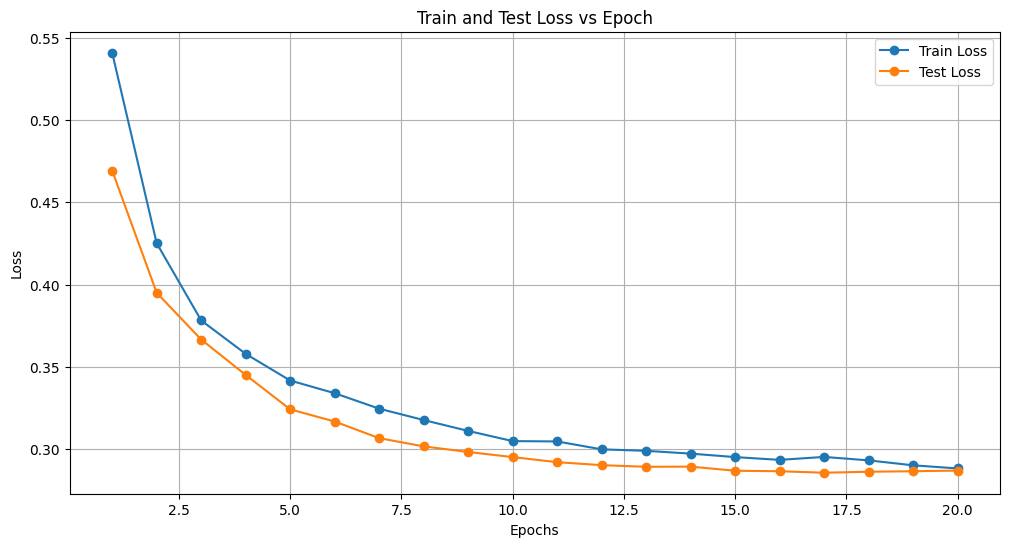

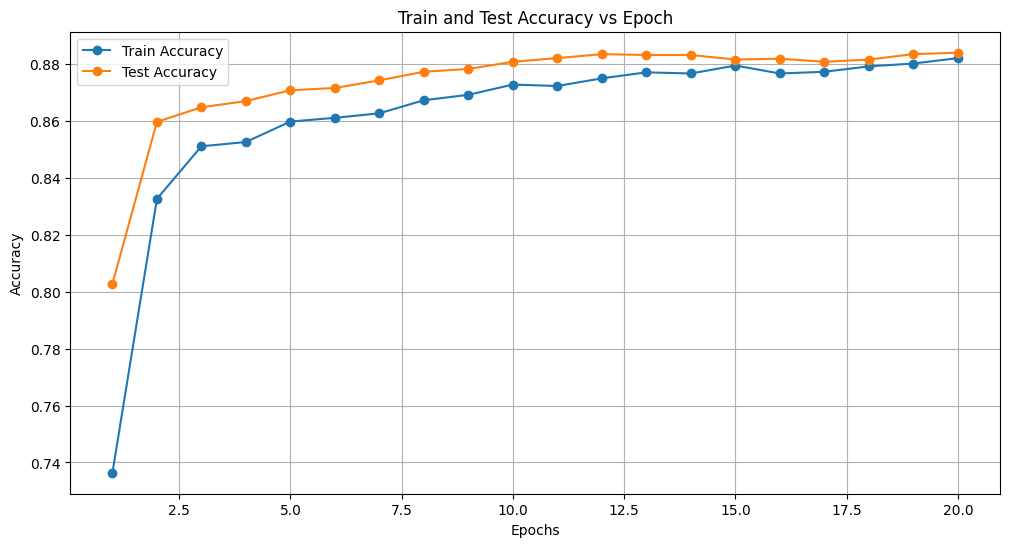

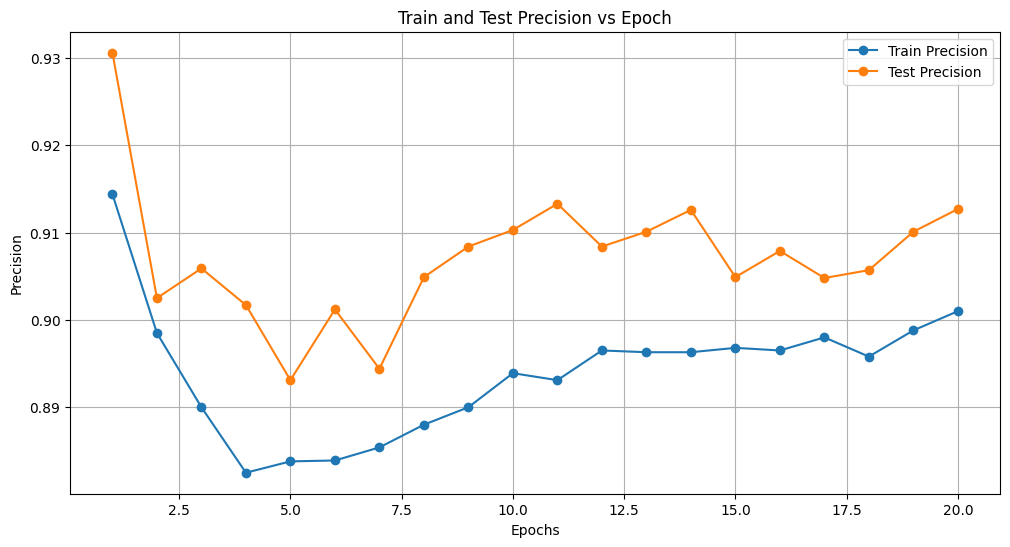

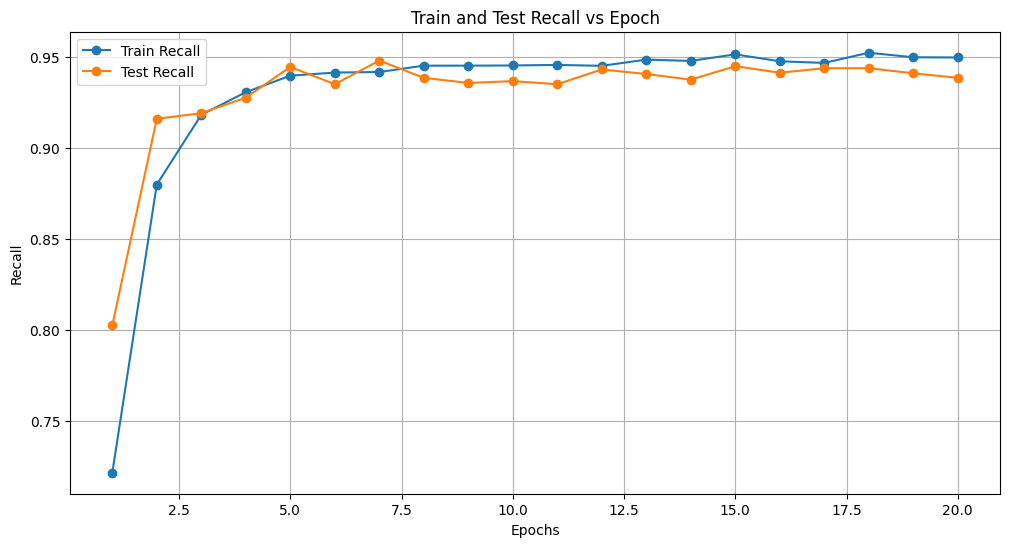

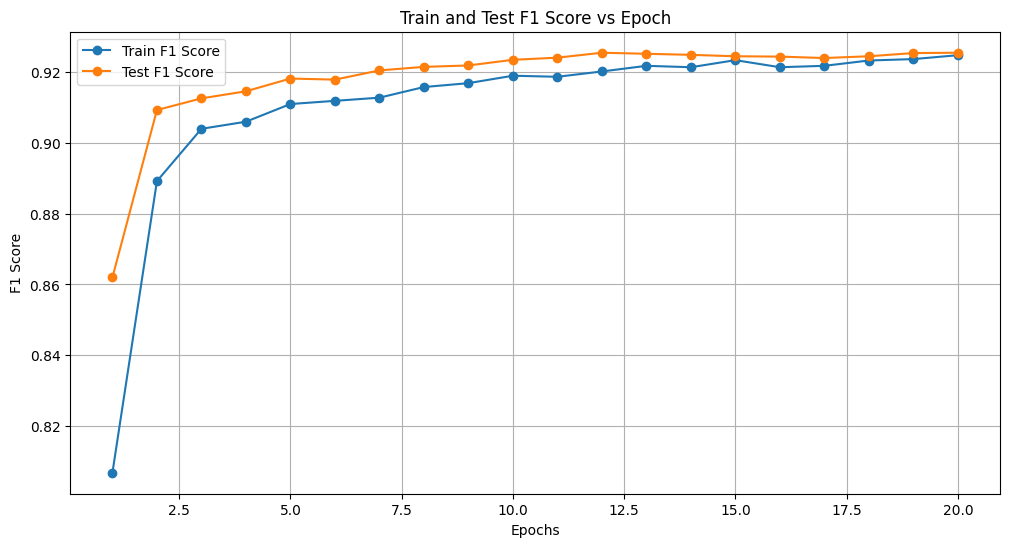

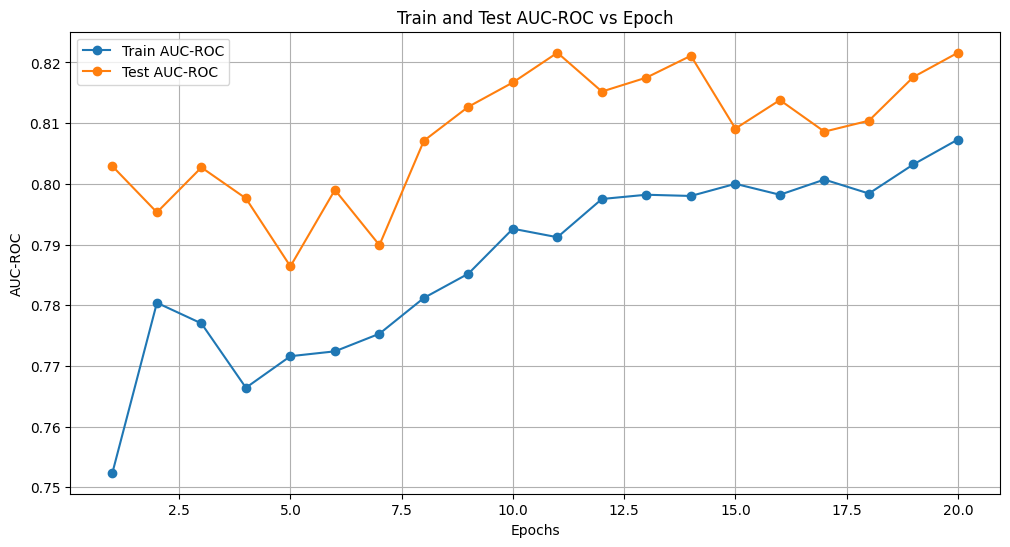

In [26]:
# import matplotlib.pyplot as plt

# # Sample data from your log
# epochs = list(range(1, 21))  # Epochs 1 to 20

# train_loss = [0.5409, 0.4252, 0.3783, 0.3580, 0.3418, 0.3341, 0.3247, 0.3178, 0.3112, 0.3050, 0.3048, 0.3000, 0.2991, 0.2974, 0.2953, 0.2936, 0.2954, 0.2933, 0.2903, 0.2884]
# test_loss = [0.4693, 0.3951, 0.3667, 0.3452, 0.3243, 0.3169, 0.3068, 0.3018, 0.2984, 0.2953, 0.2922, 0.2904, 0.2894, 0.2895, 0.2870, 0.2867, 0.2858, 0.2864, 0.2867, 0.2871]

# train_acc = [0.7364, 0.8327, 0.8512, 0.8527, 0.8599, 0.8612, 0.8628, 0.8674, 0.8693, 0.8729, 0.8724, 0.8751, 0.8772, 0.8768, 0.8796, 0.8768, 0.8774, 0.8793, 0.8803, 0.8822]
# test_acc = [0.8028, 0.8598, 0.8649, 0.8671, 0.8709, 0.8717, 0.8744, 0.8774, 0.8784, 0.8809, 0.8822, 0.8836, 0.8833, 0.8833, 0.8817, 0.8820, 0.8809, 0.8817, 0.8836, 0.8841]

# train_precision = [0.9144, 0.8985, 0.8900, 0.8825, 0.8838, 0.8839, 0.8854, 0.8880, 0.8900, 0.8939, 0.8931, 0.8965, 0.8963, 0.8963, 0.8968, 0.8965, 0.8980, 0.8958, 0.8988, 0.9010]
# test_precision = [0.9306, 0.9025, 0.9059, 0.9017, 0.8931, 0.9012, 0.8944, 0.9049, 0.9084, 0.9103, 0.9133, 0.9084, 0.9101, 0.9126, 0.9049, 0.9079, 0.9048, 0.9057, 0.9101, 0.9127]

# train_recall = [0.7218, 0.8801, 0.9184, 0.9308, 0.9399, 0.9416, 0.9419, 0.9454, 0.9454, 0.9455, 0.9458, 0.9453, 0.9487, 0.9480, 0.9516, 0.9478, 0.9469, 0.9525, 0.9500, 0.9499]
# test_recall = [0.8027, 0.9162, 0.9193, 0.9278, 0.9447, 0.9352, 0.9482, 0.9387, 0.9359, 0.9369, 0.9352, 0.9433, 0.9408, 0.9377, 0.9451, 0.9415, 0.9440, 0.9440, 0.9412, 0.9387]

# train_f1_score = [0.8068, 0.8892, 0.9040, 0.9060, 0.9110, 0.9119, 0.9128, 0.9158, 0.9169, 0.9190, 0.9187, 0.9202, 0.9218, 0.9214, 0.9234, 0.9214, 0.9218, 0.9233, 0.9237, 0.9248]
# test_f1_score = [0.8620, 0.9093, 0.9126, 0.9146, 0.9182, 0.9179, 0.9205, 0.9215, 0.9219, 0.9235, 0.9241, 0.9255, 0.9252, 0.9249, 0.9245, 0.9244, 0.9240, 0.9245, 0.9254, 0.9255]

# train_auc_roc = [0.7524, 0.7804, 0.7770, 0.7664, 0.7716, 0.7724, 0.7753, 0.7812, 0.7852, 0.7926, 0.7912, 0.7975, 0.7982, 0.7980, 0.8000, 0.7982, 0.8007, 0.7984, 0.8032, 0.8073]
# test_auc_roc = [0.8029, 0.7953, 0.8027, 0.7976, 0.7864, 0.7990, 0.7899, 0.8071, 0.8127, 0.8167, 0.8216, 0.8152, 0.8175, 0.8211, 0.8091, 0.8138, 0.8086, 0.8104, 0.8176, 0.8216]

# # Plotting Loss vs Epoch
# plt.figure(figsize=(12, 6))
# plt.plot(epochs, train_loss, label="Train Loss", marker='o')
# plt.plot(epochs, test_loss, label="Test Loss", marker='o')
# plt.title("Train and Test Loss vs Epoch")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plotting Accuracy vs Epoch
# plt.figure(figsize=(12, 6))
# plt.plot(epochs, train_acc, label="Train Accuracy", marker='o')
# plt.plot(epochs, test_acc, label="Test Accuracy", marker='o')
# plt.title("Train and Test Accuracy vs Epoch")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plotting Precision vs Epoch
# plt.figure(figsize=(12, 6))
# plt.plot(epochs, train_precision, label="Train Precision", marker='o')
# plt.plot(epochs, test_precision, label="Test Precision", marker='o')
# plt.title("Train and Test Precision vs Epoch")
# plt.xlabel("Epochs")
# plt.ylabel("Precision")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plotting Recall vs Epoch
# plt.figure(figsize=(12, 6))
# plt.plot(epochs, train_recall, label="Train Recall", marker='o')
# plt.plot(epochs, test_recall, label="Test Recall", marker='o')
# plt.title("Train and Test Recall vs Epoch")
# plt.xlabel("Epochs")
# plt.ylabel("Recall")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plotting F1 Score vs Epoch
# plt.figure(figsize=(12, 6))
# plt.plot(epochs, train_f1_score, label="Train F1 Score", marker='o')
# plt.plot(epochs, test_f1_score, label="Test F1 Score", marker='o')
# plt.title("Train and Test F1 Score vs Epoch")
# plt.xlabel("Epochs")
# plt.ylabel("F1 Score")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plotting AUC-ROC vs Epoch
# plt.figure(figsize=(12, 6))
# plt.plot(epochs, train_auc_roc, label="Train AUC-ROC", marker='o')
# plt.plot(epochs, test_auc_roc, label="Test AUC-ROC", marker='o')
# plt.title("Train and Test AUC-ROC vs Epoch")
# plt.xlabel("Epochs")
# plt.ylabel("AUC-ROC")
# plt.legend()
# plt.grid(True)
# plt.show()


In [28]:
model_path = "CandidateRankingModel_state.pth"
torch.save(model.state_dict(), model_path)
print(f"Full model saved at: {model_path}")

Full model saved at: CandidateRankingModel_state.pth
